In [1]:
## Machine Learning - Breast Tumor Classification Project

In [2]:
# EDA
# split data as test and train
# scaling (X_train,X_test)
# cross-validation
# modelling
# model evaluation

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import LinearSVC, SVC
from joblib import dump, load
import shap

In [5]:
import psycopg2

In [6]:
# Connecting Postgresql Server

In [7]:
param = {
    'host':'localhost',
    'user':'postgres',
    'port':5432,
    'password':'Reyyan2010!'
}
connection = psycopg2.connect(**param, dbname='database_ds')

In [8]:
df = pd.read_sql('select * from schema_ds.breast_cancer ', connection)

In [9]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [6,4], fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [6,4].
    fontsize: int
        Font size for axes labels. Defaults to 12.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [10]:
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = ["Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [11]:
# Reading from csv file

In [12]:
# df = pd.read_csv('breast-cancer.csv')
# source kaggle 
# (www.kaggle.com/datasets/yasserh/breast-cancer-dataset)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [14]:
df.isnull().sum() # null values

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [15]:
df.duplicated().sum() # duplicate values

0

In [16]:
df.drop(['id'], axis=1 , inplace=True)

In [17]:
df.tail()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
564         0.1726  ...        25.450          26.40           166.10   
565         0.1752  ...        23.690          38.25           155.00   
566         0.1590  ...        18.980          34.12           126.70   
567         0.2397  ...        25.740          39.42           184.60   
568         0.1587  ...         9.456          30.37            59.16   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
564      2027.0           0.14100            0.21130           0.4107   
565      1731.0           0.11660            0.19220           0.3215   
566      1124.0           0.11390            0.30940           0.3403   
567      1821.0           0.16500            0.86810           0.9387   
568       268.6           0.08996            0.06444           0.0000   

     concave_points_worst  symmetry_worst  fractal_dimension_worst  
564                0.2216          0.2060                  0.07115  
565                0.1628          0.2572                  0.06637  
566                0.1418          0.2218                  0.07820  
567                0.2650          0.4087                  0.12400  
568                0.0000          0.2871                  0.07039  

[5 rows x 31 columns]

In [19]:
df['diagnosis'].value_counts(normalize=True) # ratios as percentages

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [20]:
df['diagnosis']

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [21]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [22]:
df.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       compactness_worst  concavity_worst  concave_points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

In [23]:
df['target']=df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

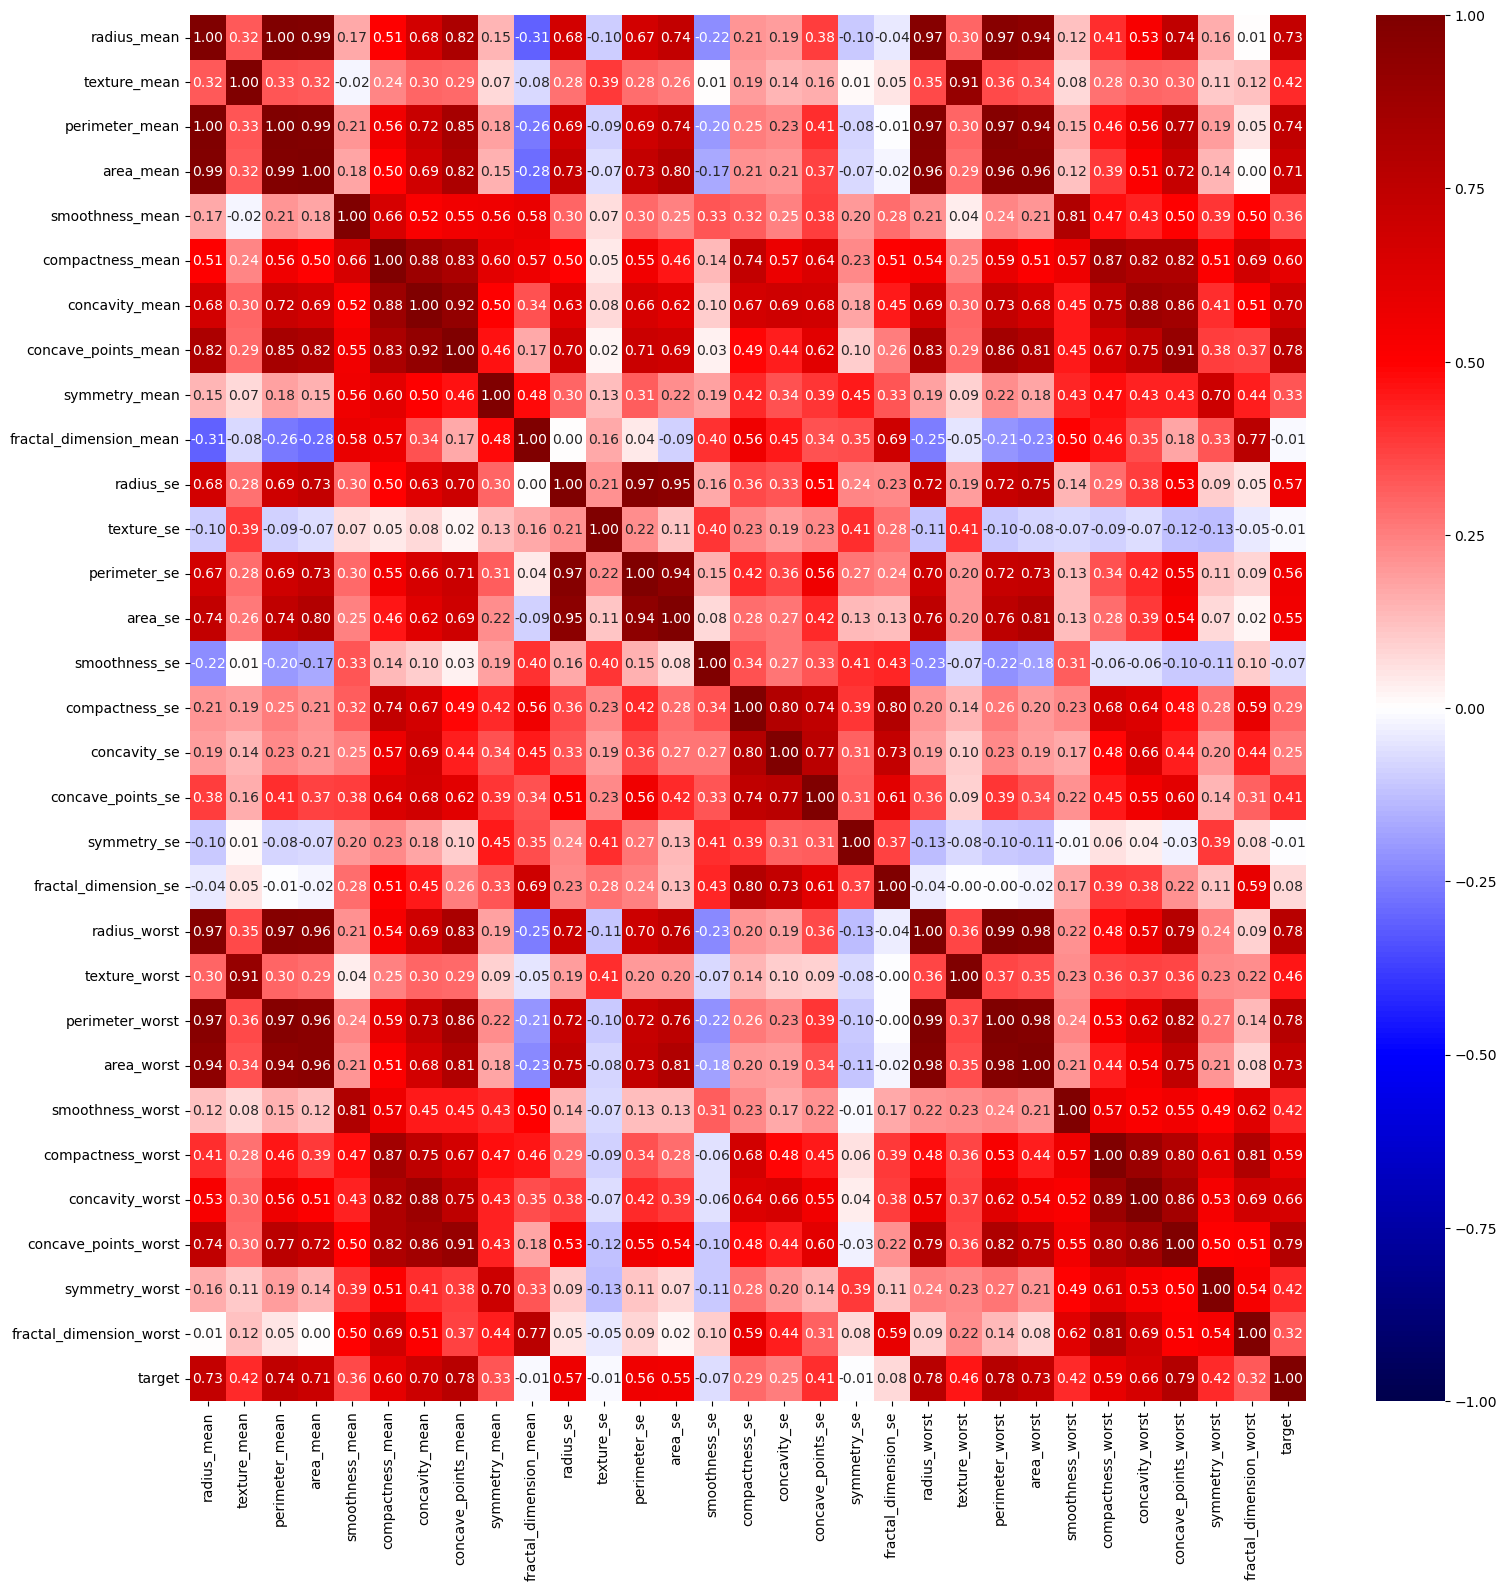

In [24]:
plt.figure(figsize=[18,18])
sns.heatmap(df.corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

In [25]:
# Dropping the columns have multicolonarity

In [26]:
new_df = df.drop(['radius_mean', 'texture_mean', 'perimeter_mean','area_mean',
                  'smoothness_mean', 'concave_points_mean', 'symmetry_mean', 
                  'fractal_dimension_mean','texture_se', 'perimeter_se', 'area_se',
                  'smoothness_se','concavity_se', 'concave_points_se', 
                  'symmetry_se','fractal_dimension_se', 'radius_worst', 
                  'texture_worst','perimeter_worst', 'area_worst', 'smoothness_worst',
                  'concavity_worst'], axis=1)

In [27]:
# Defining features(X) and target(y)

In [28]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

print(X.shape)
print(y.shape)

(569, 8)
(569,)


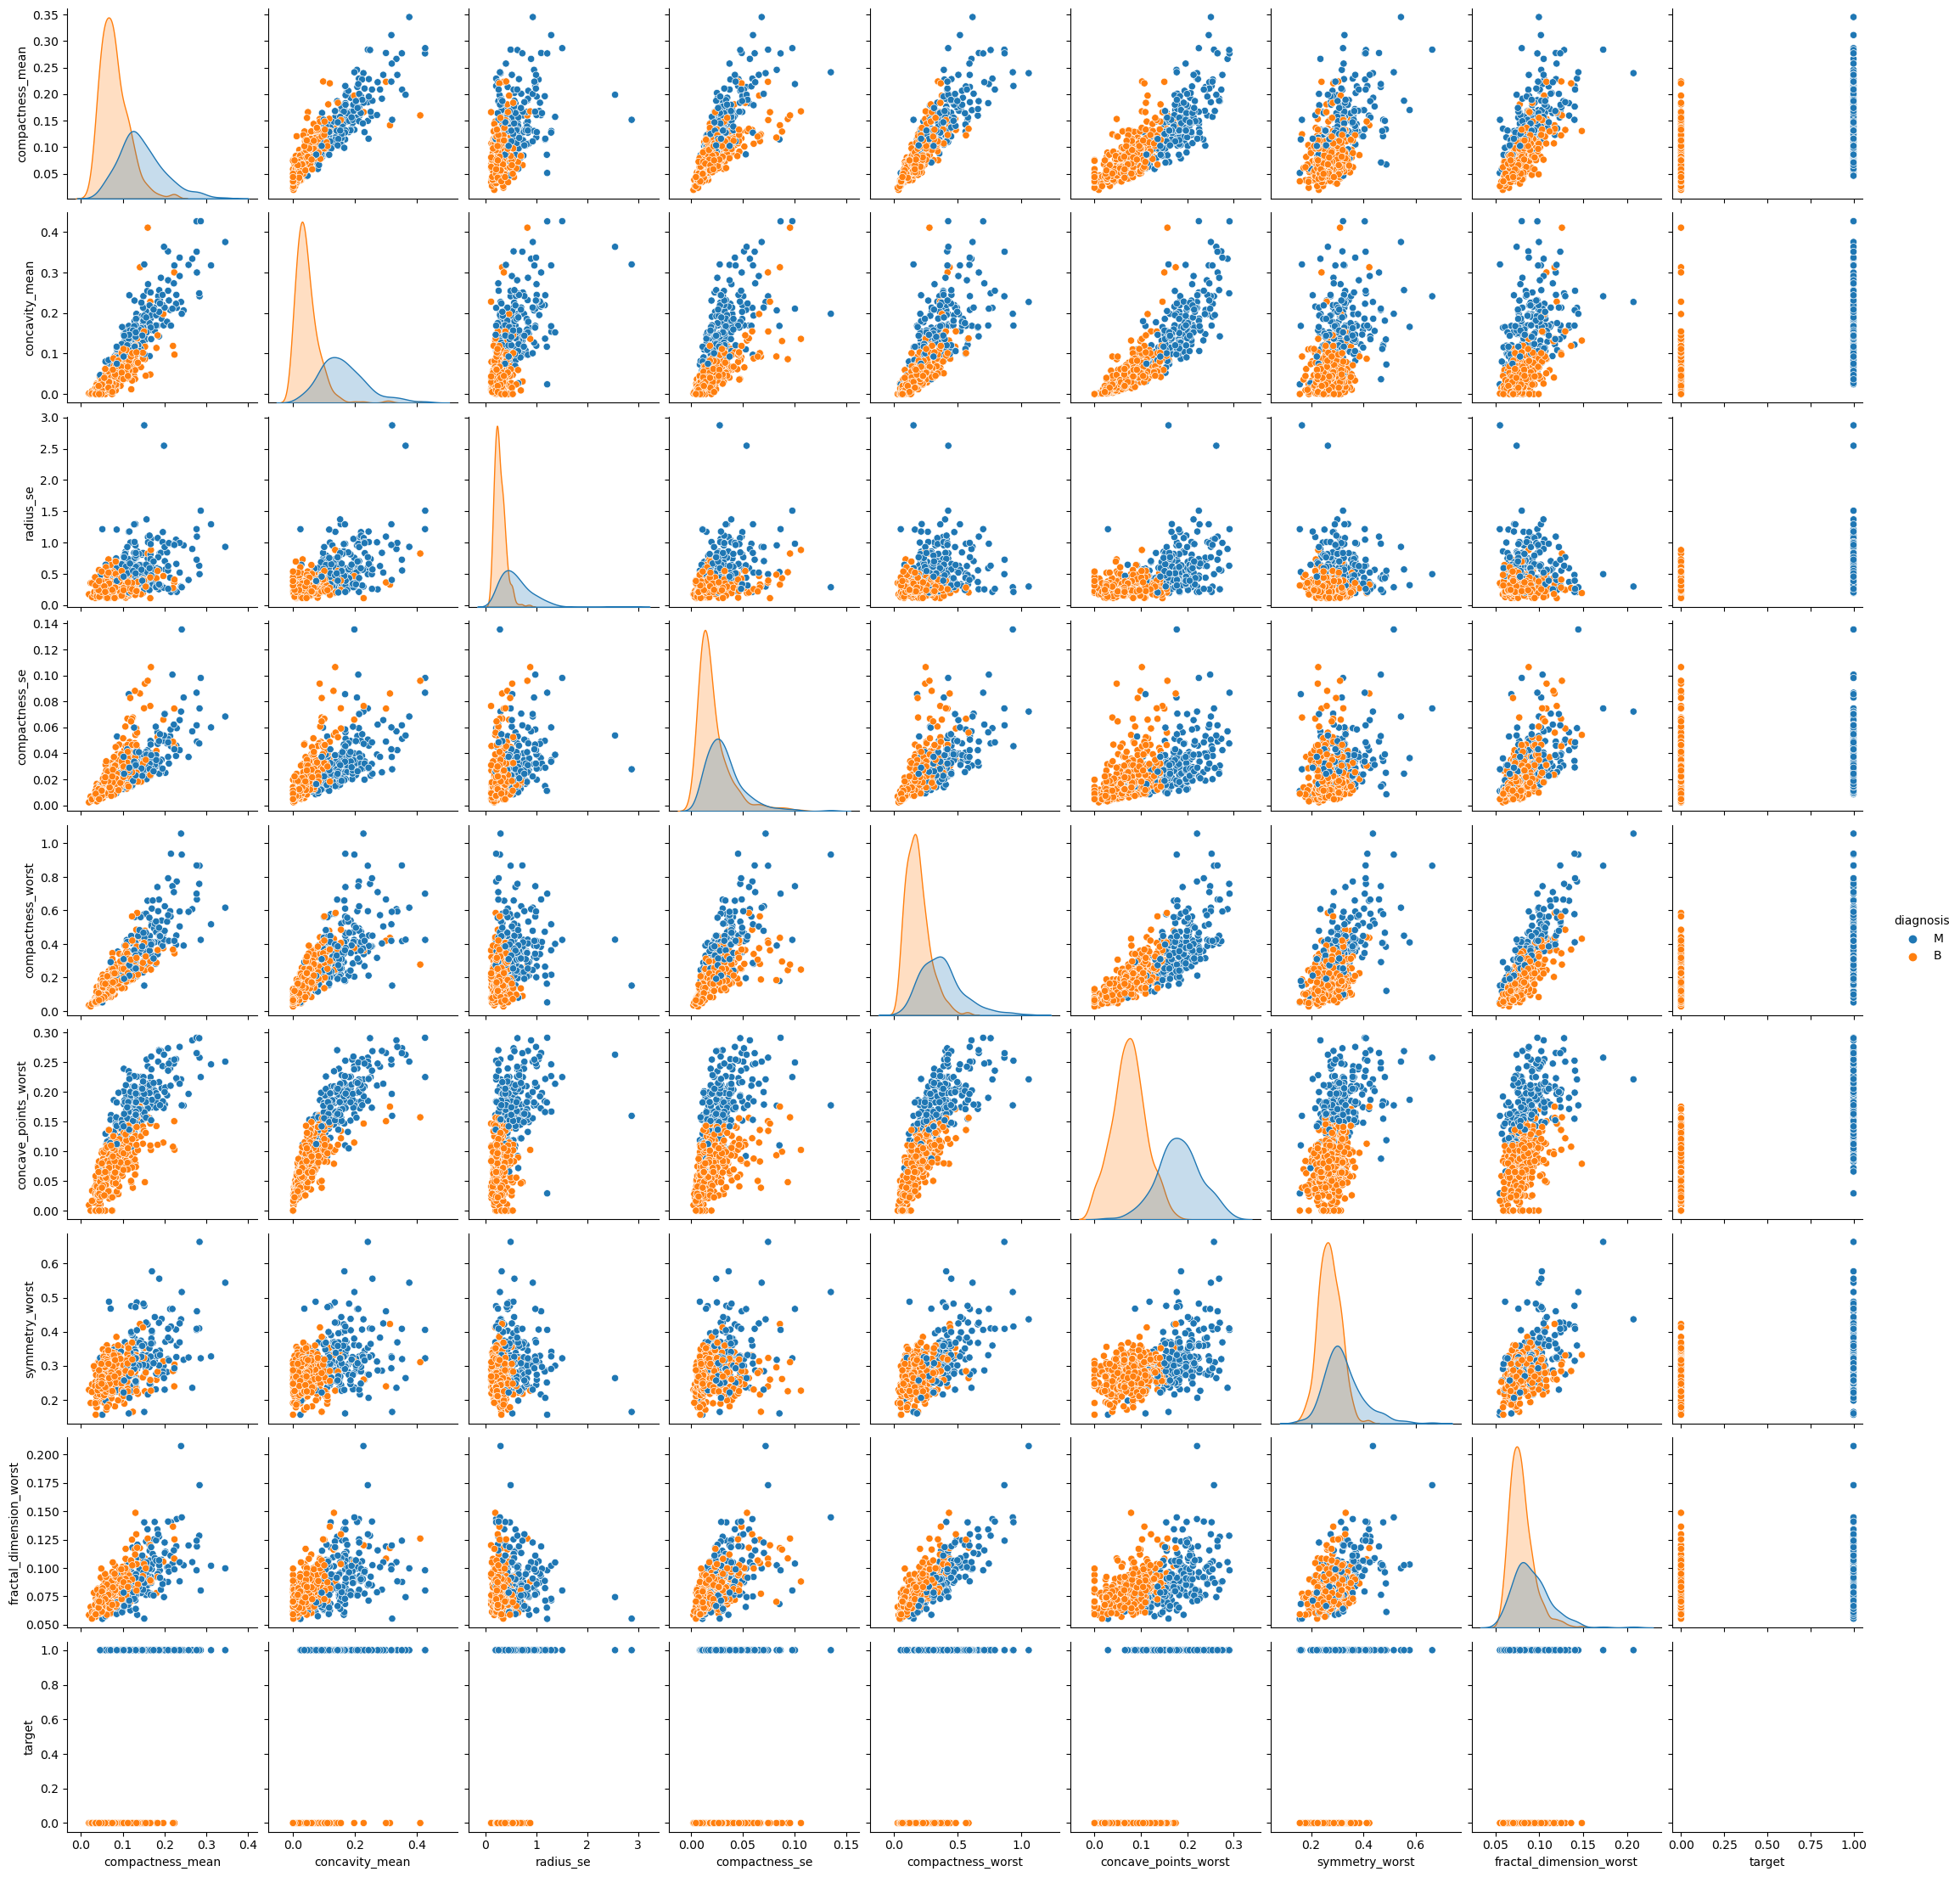

In [29]:
sns.pairplot(new_df, hue='diagnosis');

In [30]:
# Spliting data into train and test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size = 0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(455, 8)
(114, 8)
(455,)
(114,)


In [32]:
# Implementing Scaling

In [33]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train) # fit_transform for train
X_test_scaled = std_scale.transform(X_test) # transform fot test

In [34]:
# Logistic Regression

In [35]:
score = []
logr = LogisticRegression(solver='liblinear')
logr.fit(X_train_scaled, y_train)

score = cross_val_score(estimator=logr, X=X_train_scaled, y=y_train, 
                        scoring='accuracy', cv=5)
print('Logistic Regression CV Scores:',np.round(score,3))
print('Logistic Regression Mean Score:',round(score.mean(),3) )

Logistic Regression CV Scores: [0.945 0.912 0.978 0.956 0.945]
Logistic Regression Mean Score: 0.947


In [36]:
print("Logistic Regression Testing Accuracy:", 
      round(logr.score(X_test_scaled, y_test),3))

Logistic Regression Testing Accuracy: 0.939


In [37]:
print('Logistic Regression Confusion Matrix: \n\n', 
      confusion_matrix(y_test, logr.predict(X_test_scaled)))

Logistic Regression Confusion Matrix: 

 [[68  3]
 [ 4 39]]


In [38]:
print("Log-Loss on LogReg: {:6.3f}".format(log_loss(y_test, logr.predict_proba(X_test_scaled))))

Log-Loss on LogReg:  0.130


In [39]:
np.set_printoptions(suppress=True, precision= 2)
logr.predict_proba(X_test_scaled)

array([[0.74, 0.26],
       [0.  , 1.  ],
       [0.07, 0.93],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.08, 0.92],
       [0.12, 0.88],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.07, 0.93],
       [0.99, 0.01],
       [0.51, 0.49],
       [0.9 , 0.1 ],
       [0.42, 0.58],
       [0.97, 0.03],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.71, 0.29],
       [0.97, 0.03],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.93, 0.07],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.01, 0.99],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.86, 0.14],
       [0.97, 0.03],
       [0.99, 0.01],
       [0.95, 0.05],
       [0.81, 0.19],
       [0.62, 0.38],
       [0.02, 0.98],
       [0.96, 0.04],
       [0.99, 0.01],
       [0.06, 0.94],
       [0.89, 0.11],
       [0.99, 0.01],
       [0.52, 0.48],
       [0.96, 0.04],
       [0.97, 0.03],
       [0.99,

In [40]:
print('Logistic Reggression')
evaluate_model(logr, X_test_scaled, y_test, pred_label=1) # "M"=1

Logistic Reggression


Accuracy  Recall  Precision  F1 Score  AUC Score
Class 1     0.939   0.907      0.929     0.918      0.932

In [41]:
evaluate_model(logr, X_test_scaled, y_test, pred_label=0) # "B"=0

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 0     0.939   0.958      0.944     0.951      0.932

In [42]:
def make_confusion_matrix(model, threshold=0.5): # Ön tanımlı threshold değeri
    
    y_predict = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    tumor_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=80)
    sns.heatmap(tumor_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['B', 'M'],
           yticklabels=['B', 'M']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

In [43]:
# Threshold değerini değiştirdiğimizde sonucun da interaktif bir şekilde değişmesi için bir widget

from ipywidgets import interactive

interactive(lambda threshold: make_confusion_matrix(logr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [44]:
# 0.18 threshold değerine göre sınıflandırma
new_threshold = 0.18
y_predict = (logr.predict_proba(X_test_scaled)[:,1] > new_threshold)
print('New Threshold:', new_threshold)
print('Precision: {:6.3f},\n   Recall: {:6.3f}, \n Accuracy: {:6.3f}'.format(precision_score(y_test, y_predict), recall_score(y_test, y_predict),accuracy_score(y_test, y_predict)))

New Threshold: 0.18
Precision:  0.811,
   Recall:  1.000, 
 Accuracy:  0.912


In [45]:
np.set_printoptions(suppress=True, precision= 2)
logr.predict_proba(X_test_scaled)

array([[0.74, 0.26],
       [0.  , 1.  ],
       [0.07, 0.93],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.08, 0.92],
       [0.12, 0.88],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.07, 0.93],
       [0.99, 0.01],
       [0.51, 0.49],
       [0.9 , 0.1 ],
       [0.42, 0.58],
       [0.97, 0.03],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.71, 0.29],
       [0.97, 0.03],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.93, 0.07],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.01, 0.99],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.86, 0.14],
       [0.97, 0.03],
       [0.99, 0.01],
       [0.95, 0.05],
       [0.81, 0.19],
       [0.62, 0.38],
       [0.02, 0.98],
       [0.96, 0.04],
       [0.99, 0.01],
       [0.06, 0.94],
       [0.89, 0.11],
       [0.99, 0.01],
       [0.52, 0.48],
       [0.96, 0.04],
       [0.97, 0.03],
       [0.99,

In [47]:
importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.abs(np.round(logr.coef_.reshape(8,),3))})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances.head(8)

Importance
Feature                            
concave_points_worst          2.579
radius_se                     2.425
compactness_worst             1.773
compactness_se                1.289
fractal_dimension_worst       0.917
concavity_mean                0.895
compactness_mean              0.665
symmetry_worst                0.621

In [48]:
# K-Nearest Neighbors(KNN)

In [49]:
knn = KNeighborsClassifier()

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'minkowski']
param_grid = dict(n_neighbors=k_range, weights=weight_options, 
                  metric=metric_options)

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print("Best Score: ",round(grid.best_score_,3))
print("Best Parameters:",grid.best_params_)

Best Score:  0.934
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


In [50]:
knn_scores = []

knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, 
                           weights = 'uniform')
knn_scores = cross_val_score(estimator=knn, X=X_train_scaled, 
                             y=y_train, scoring='accuracy', cv=5)
print('KNN CV Scores: ', knn_scores)
print('KNN Mean Score:', round(knn_scores.mean(),3) )

KNN CV Scores:  [0.91 0.91 0.95 0.97 0.91]
KNN Mean Score: 0.93


In [51]:
knn.fit(X_train_scaled, y_train)
print('KNN Confusion Matrix: \n\n', confusion_matrix(y_test, 
                                                     knn.predict(X_test_scaled)))

KNN Confusion Matrix: 

 [[68  3]
 [ 3 40]]


In [52]:
print("KNN Testing Accuracy:", 
      round(knn.score(X_test_scaled, y_test),3))

KNN Testing Accuracy: 0.947


In [53]:
knn.predict_proba(X_test_scaled)

array([[1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.33, 0.67],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.67, 0.33],
       [0.33, 0.67],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.33, 0.67],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [0.67, 0.33],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  ,

In [54]:
print("Log-Loss on KNN: {:6.3f}".format(log_loss(y_test, knn.predict_proba(X_test_scaled))))

Log-Loss on KNN:  0.731


In [55]:
evaluate_model(knn, X_test_scaled, y_test, pred_label=1) # "M"=1

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 1     0.947    0.93       0.93      0.93      0.944

In [56]:
evaluate_model(knn, X_test_scaled, y_test, pred_label=0) # "B"=0

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 0     0.947   0.958      0.958     0.958      0.944

In [57]:
# Decision Tree

In [58]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

results = cross_val_score(dt_model, X_train, y_train, cv=5)
print("Decision Tree CV Accuracy Scores: ", np.round(results,3))
print("Decision Tree CV Accuracy Mean: ", np.round(results.mean(),3))

Decision Tree CV Accuracy Scores:  [0.91 0.88 0.92 0.91 0.91]
Decision Tree CV Accuracy Mean:  0.908


In [59]:
y_pred_dt = dt_model.predict(X_test)
confusion_matrix(y_test, y_pred_dt)

array([[66,  5],
       [ 4, 39]])

In [60]:
print("Decision Tree Testing Accuracy:", 
      round(dt_model.score(X_test, y_test),3))

Decision Tree Testing Accuracy: 0.921


In [61]:
evaluate_model(dt_model, X_test, y_test, pred_label=1) # "M"=1

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 1     0.921   0.907      0.886     0.897      0.918

In [62]:
evaluate_model(dt_model, X_test, y_test, pred_label=0) # "B"=0

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 0     0.921    0.93      0.943     0.936      0.918

In [63]:
import numpy as np
importances_dt = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(dt_model.feature_importances_,3)})
importances_dt = importances_dt.sort_values('Importance', ascending=False).set_index('Feature')
importances_dt

Importance
Feature                            
concave_points_worst          0.761
radius_se                     0.108
fractal_dimension_worst       0.039
compactness_se                0.027
symmetry_worst                0.027
concavity_mean                0.022
compactness_mean              0.008
compactness_worst             0.007

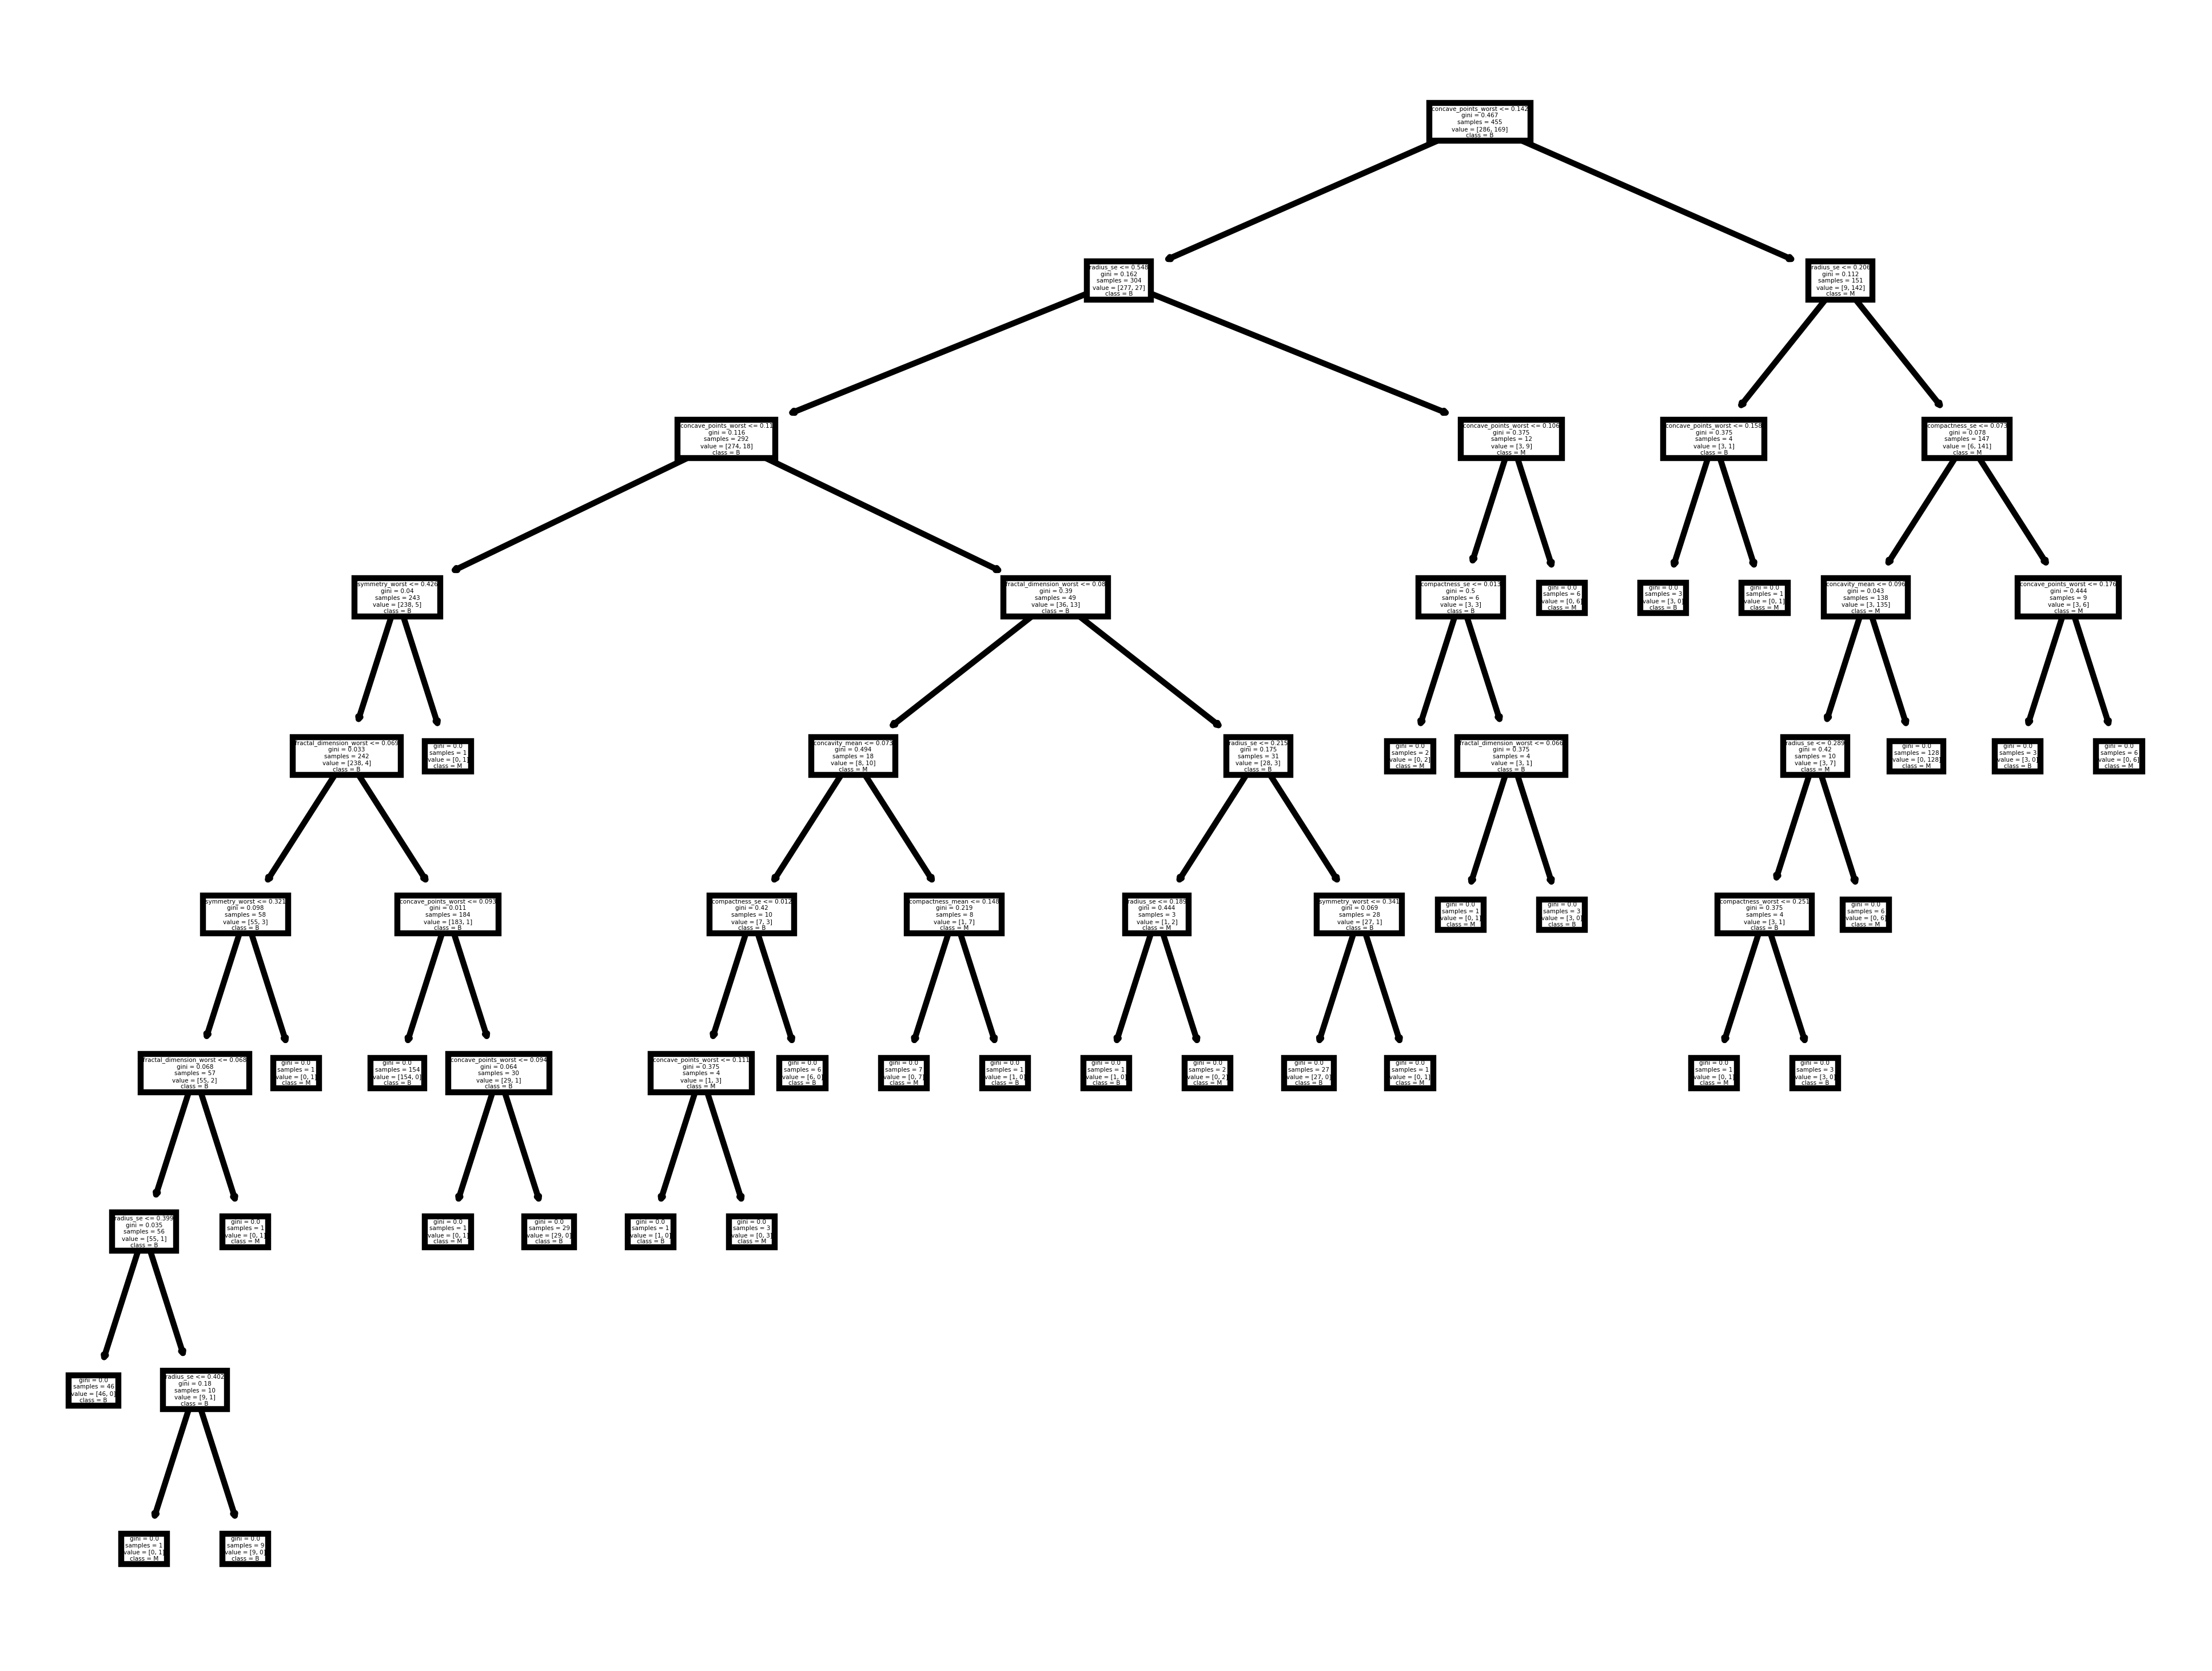

In [64]:
plt.figure(dpi=750)
plot_tree(dt_model, feature_names=X.columns, class_names=['B','M']);

In [65]:
# Random Forest

In [66]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, 
                                                    random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
results = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Random Forest CV Accuracy Scores: ", np.round(results,3))
print("Random Forest CV Accuracy Mean: ", np.round(results.mean(),3))

Random Forest CV Accuracy Scores:  [0.91 0.91 0.97 0.96 0.93]
Random Forest CV Accuracy Mean:  0.936


In [68]:
y_pred_rf = rf_model.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

array([[68,  3],
       [ 3, 40]])

In [69]:
evaluate_model(rf_model, X_test, y_test, pred_label=1) # "M"=1

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 1     0.947    0.93       0.93      0.93      0.944

In [70]:
evaluate_model(rf_model, X_test, y_test, pred_label=0) # "B"=0

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 0     0.947   0.958      0.958     0.958      0.944

In [71]:
importances_rf = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_rf = importances_rf.sort_values('Importance', ascending=False).set_index('Feature')
importances_rf

Importance
Feature                            
concave_points_worst          0.348
concavity_mean                0.194
radius_se                     0.133
compactness_mean              0.104
compactness_worst             0.084
compactness_se                0.053
symmetry_worst                0.046
fractal_dimension_worst       0.039

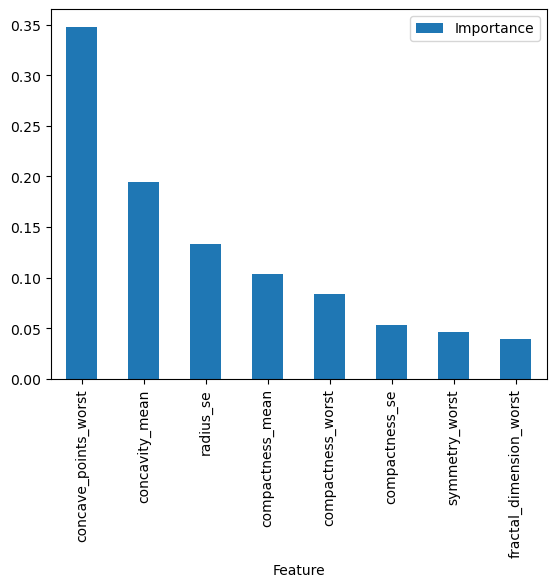

In [72]:
importances_rf.plot.bar();

In [73]:
# Xgboost

In [74]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values_classification = explainer(X_test)

In [75]:
results = cross_val_score(xgb_model, X_train, y_train, cv=5)
print("Xgboost CV Accuracy Scores: ", np.round(results,3))
print("Xgboost CV Accuracy Mean: ", np.round(results.mean(),3))

Xgboost CV Accuracy Scores:  [0.94 0.89 0.98 0.96 0.96]
Xgboost CV Accuracy Mean:  0.945


In [76]:
y_pred = xgb_model.predict(X_test)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("XGBoost Test Accuracy: ", round(accuracy,2))

XGBoost Test Accuracy:  0.94


In [77]:
print('Xgboost Test Accuracy:')
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Xgboost Test Accuracy:
[[66  5]
 [ 2 41]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        71
           1       0.89      0.95      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114



In [78]:
shap.initjs()

In [79]:
X_test.join(y_test)

compactness_mean  concavity_mean  radius_se  compactness_se  \
204           0.10580         0.08005     0.3961         0.01911   
70            0.10290         0.10800     0.7888         0.01652   
131           0.12230         0.14660     0.4743         0.01484   
431           0.13160         0.07741     0.1767         0.03295   
540           0.11200         0.06737     0.2784         0.04112   
..                ...             ...        ...             ...   
486           0.06698         0.05192     0.2204         0.01393   
75            0.08424         0.09769     0.7474         0.02203   
249           0.07808         0.04328     0.2562         0.01228   
238           0.10390         0.11030     0.3354         0.02845   
265           0.11430         0.13670     1.1720         0.01478   

     compactness_worst  concave_points_worst  symmetry_worst  \
204             0.2378               0.10150          0.3014   
70              0.2336               0.17890          0.2551   
131             0.2394               0.15140          0.2837   
431             0.2629               0.07370          0.2556   
540             0.2118               0.06918          0.2329   
..                 ...                   ...             ...   
486             0.2070               0.07828          0.2455   
75              0.2045               0.15200          0.2650   
249             0.1582               0.09608          0.2664   
238             0.2426               0.08219          0.1890   
265             0.2644               0.16590          0.2868   

     fractal_dimension_worst  diagnosis  
204                  0.08750          0  
70                   0.06589          1  
131                  0.08019          1  
431                  0.09359          0  
540                  0.08134          0  
..                       ...        ...  
486                  0.06596          0  
75                   0.06387          1  
249                  0.07809          0  
238                  0.07796          0  
265                  0.08218          1  

[114 rows x 9 columns]

In [80]:
# Using Shap explainer

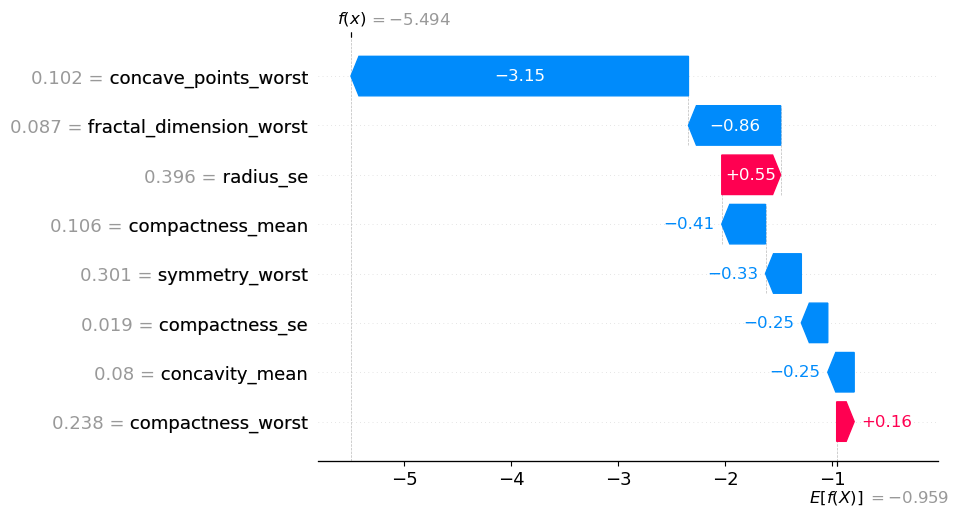

In [81]:
shap.plots.waterfall(shap_values_classification[0])

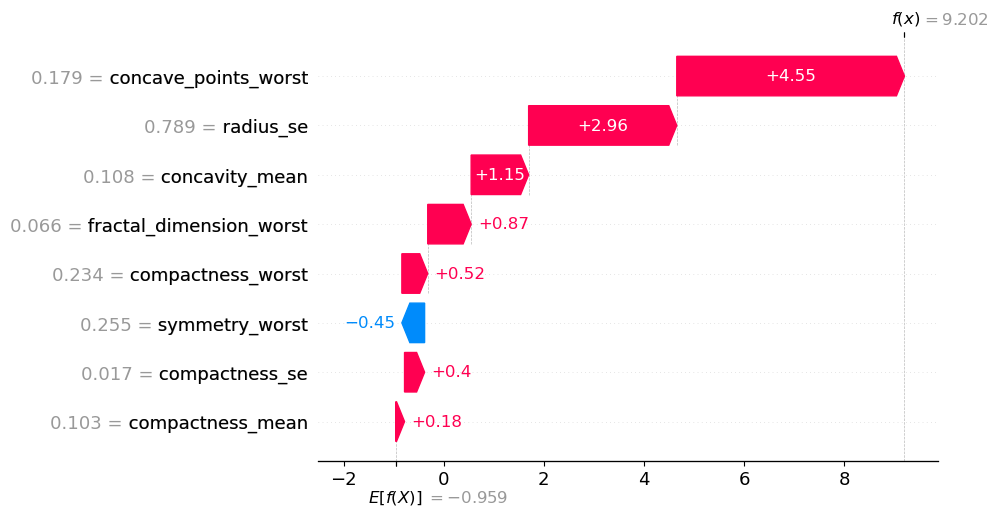

In [82]:
shap.plots.waterfall(shap_values_classification[1])

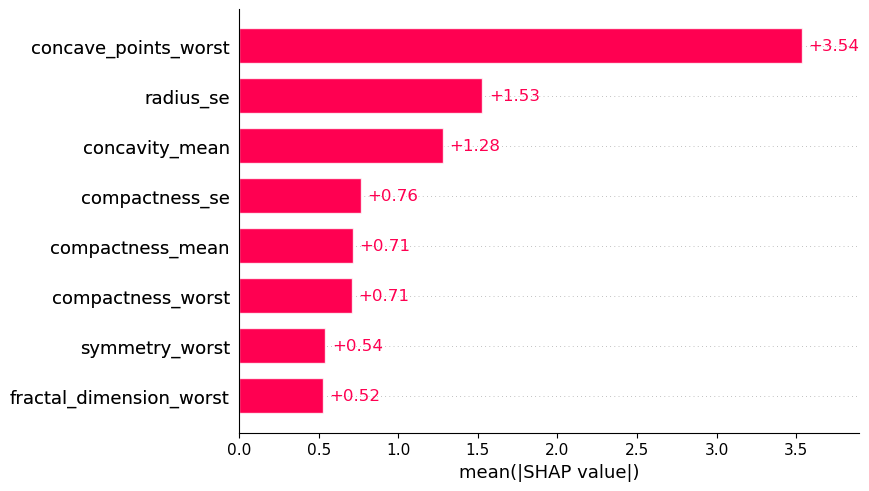

In [83]:
shap.plots.bar(shap_values_classification)

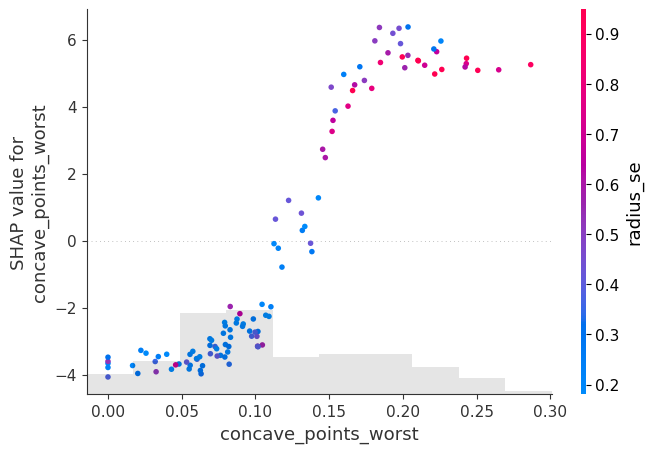

In [84]:
shap.plots.scatter(shap_values_classification[:, "concave_points_worst"], color=shap_values_classification[:, "radius_se"])

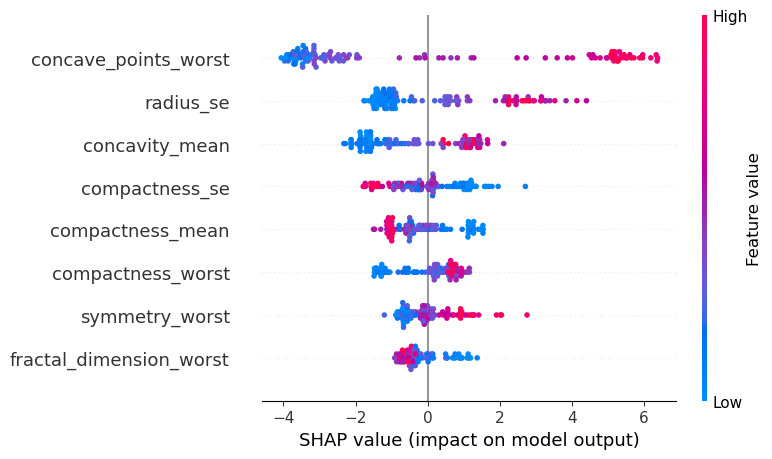

In [85]:
shap.summary_plot(shap_values_classification, X_test, )

In [86]:
# Support Vector Classifier (SVC) 

In [87]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2,random_state=42, stratify=y)

svc = SVC().fit(X_train, y_train)

results = cross_val_score(svc, X_train, y_train, cv=5)
print("SVC CV Accuracy Scores: ", np.round(results,3))
print("SVC CV Accuracy Mean: ", np.round(results.mean(),3))

SVC CV Accuracy Scores:  [0.93 0.96 0.93 0.9  0.9 ]
SVC CV Accuracy Mean:  0.925


In [88]:
y_pred_svc = svc.predict(X_test)
confusion_matrix(y_test, y_pred_svc)

array([[71,  1],
       [ 7, 35]])

In [89]:
print("Decision Tree Testing Accuracy:", 
      round(svc.score(X_test, y_test),3))

Decision Tree Testing Accuracy: 0.93


In [90]:
evaluate_model(svc, X_test, y_test, pred_label=1) # "M"=1

Accuracy  Recall  Precision  F1 Score  AUC Score
Class 1      0.93   0.833      0.972     0.897       0.91

In [91]:
# Saving the best models as a pickle file

In [92]:
dump(knn, 'knn_model.pkl')

['knn_model.pkl']

In [93]:
dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [94]:
data={'model':['LR','KNN','DT','RF','XGB','SVC'],
        'score':[0.939,0.947,0.921, 0.947,0.94,0.93] 
     }

In [95]:
model_df = pd.DataFrame(data)

In [96]:
import plotly.express as px

model_df.sort_values('score',inplace=True,ascending=False)
fig = px.bar(model_df, x="model", y="score", title="Models and Scores", text_auto=True, color="score")
fig.show()
